## Offline analysis

here we will explore

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
plt.style.use('science')

---
### Energy
Let us start this notebook by first analyzing the accuracy of our code. The gravitational problem is an example of an Hamiltonian system described by the Hamiltonian:
$$
H(\vec r, \vec v) = \frac{1}{2}\sum_i m_i v_i^2 + \frac{1}{2}\sum_{i\neq j} \frac{G m_i m_j}{r_{ij}}
$$
conserved ($H=const$) throughout the dynamical evolution of the closed system. Therefore, to assess the quality and stability of our numerical integrators, we can monitor the fluctuations of the computed empirical energy $E(t)$ over time. A stable integrator should maintain $E(t)$ nearly constant, with only bounded oscillations due to numerical precision.

We used two different integration schemes: **Velocity Verlet** (symplectic, stable) and **Euler** (first-order, unstable). For each integrator, we compared the total energy evolution $E(t)$ across three different hardware/software implementations:

1.  **Serial:** The baseline reference implementation. Code is executed on my CPU, single-thread
2.  **OpenMP:** Multi-threaded CPU execution. Code is executed in parallel thanks to OpenMP, still on the CPU
3.  **CUDA:** GPU execution

The specific parallelization paradigm (CPU, GPU ...) should not alter the *physics* of the solution, hence we should obtain similar results. However, to rigorously verify algorithmic correctness as a sanity check, these simulations were performed on all three implementations. Most importantly, we also analyized how switching from Double to Float may affect the energy conservation

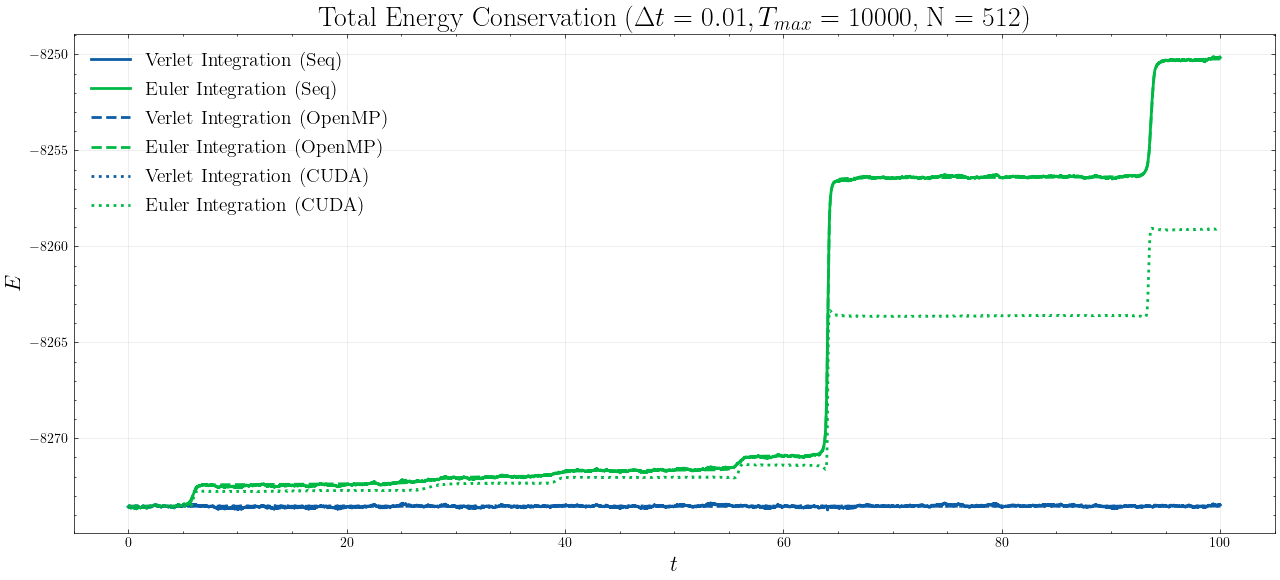

In [3]:
plt.figure(figsize=(13,6), dpi = 100)
prec = "Float"
# Sequential data
filenameVerlet = f"../data/CPUSequential/energyVerlet{prec}.dat"
filenameEuler = f"../data/CPUSequential/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, label='Verlet Integration (Seq)', lw = 2, color='C0')
plt.plot(time, energyEuler, label='Euler Integration (Seq)', lw = 2, color='C1')

# OpenMP, nthreads = 8 
filenameVerlet = f"../data/CPUParallel/energyVerlet{prec}.dat"
filenameEuler = f"../data/CPUParallel/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, '--', label='Verlet Integration (OpenMP)', lw = 2,color='C0')
plt.plot(time, energyEuler, '--', label='Euler Integration (OpenMP)', lw = 2, color='C1')

# CUDA, naive
filenameVerlet = f"../data/GPU/energyVerlet{prec}.dat"
filenameEuler = f"../data/GPU/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, ':', label='Verlet Integration (CUDA)', lw = 2,color='C0')
plt.plot(time, energyEuler, ':', label='Euler Integration (CUDA)', lw = 2, color='C1')


plt.title(r'Total Energy Conservation     ($\Delta t = 0.01, T_{max} = 10000$, N = 512)', fontsize=20)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E$', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As expected, Euler integration greatly violates energy conservation. This behavior is intrinsic to the algorithm: being a first-order method ($O(\Delta t)$), it introduces a systematic error at every time step. In orbital mechanics, this error manifests as a constant "energy drift," causing the system to gain non-physical energy: this is particularly evident for specific time where the energy abruptly increases. Those are points where bodies are colliding violently into each other and where the accuracy of Euler is at its lowest (causing injection of spurious energy into the system if $\Delta t$ is not small enough)

In contrast, the Velocity Verlet integrator demonstrates good stability. It preserves the geometric properties of the phase space and, while the energy is not conserved *exactly* (due to discrete time-stepping), it oscillates within a bounded interval rather than drifting linearly. This "bounded error" property makes Verlet suitable for long-term N-Body simulations.

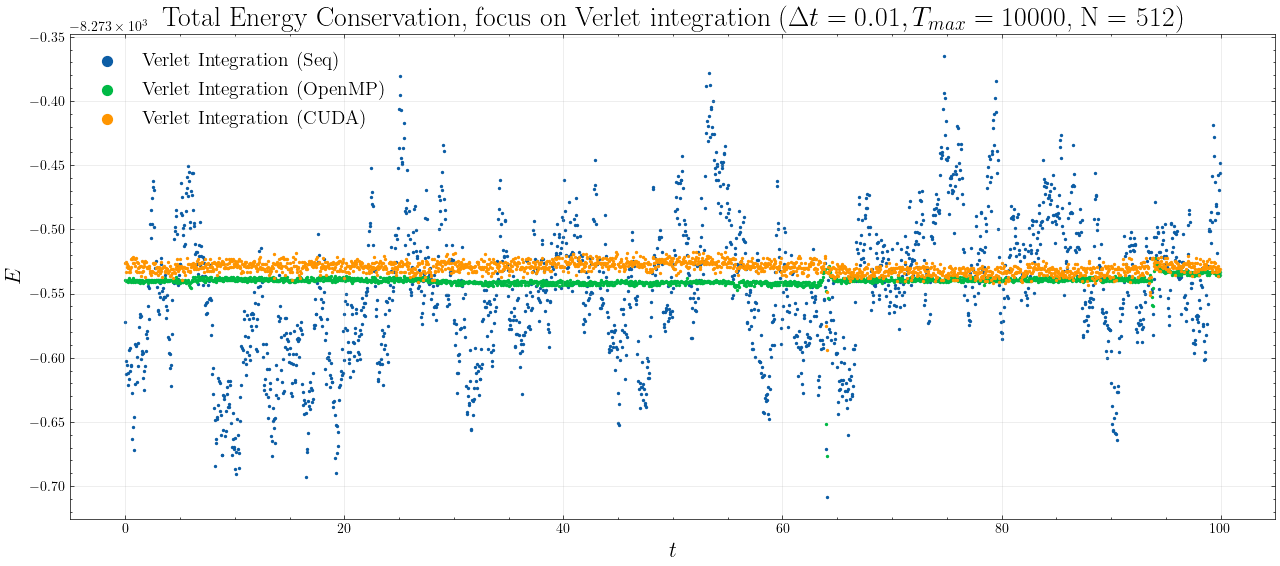

In [4]:
plt.figure(figsize=(13,6), dpi = 100)
prec = "Float"
# Sequential data
filenameVerlet = f"../data/CPUSequential/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (Seq)', s = 2)

# OpenMP, nthreads = 8 (but useless)
filenameVerlet = f"../data/CPUParallel/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (OpenMP)', s = 2)

# CUDA, naive
filenameVerlet = f"../data/GPU/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (CUDA)', s = 2)

plt.title(r'Total Energy Conservation, focus on Verlet integration     ($\Delta t = 0.01, T_{max} = 10000$, N = 512)', fontsize=20)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E$', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, markerscale=5) 
plt.tight_layout()
plt.show()

For all three implementations (Sequential, OpenMP, and CUDA), the relative error in total energy remains sufficiently low and well-bounded. This confirms that the simulation avoid the unbounded energy drift typically associated with non-symplectic integrators, such as the Euler method. Quantitatively, we observe fluctuations of approximately $\pm 0.3$ against a total energy of $E \approx -8273$, corresponding to a relative error in the order of $10^{-5}$. Hence, the Verlet integrator will be used as numerical integrator for the remainder of this notebook.


An interesting phenomena can be observed: the numerical noise in the Verlet integrator appears slightly more pronounced in the Serial CPU implementation compared to the parallel versions. This behavior can be attributed to the non-associative nature of floating-point arithmetic (we used Float). In the serial implementation, potential energy is computed via a linear accumulation into a single variable. As the accumulator grows large, adding small subsequent contributions leads to a loss of precision due to truncation. In contrast, the parallel implementations (OpenMP and CUDA) inherently employ tree-reduction patterns or thread-local partial sums. These methods sum values of similar magnitude for a longer duration before the final aggregation, effectively acting as a numerical stabilizer and reducing the overall round-off error

## OpenMP: speedup and efficiency

We now proceed to analyze the computational performance of our simulation, specifically comparing the baseline implementation (**Serial CPU**) against the parallel implementation using OpenMP. The primary metric used for comparison is the wall-clock time required to complete a simulation of $N$ bodies for a total of $1000$ time-steps. To ensure the benchmark measures pure computational throughput (FLOPS) rather than disk latency, file I/O was disabled during these tests.

The timing measurement is implemented as follows (we do not want to measure the construction time too):

```cpp
Simulation sim(nParticles, dt, L);
auto start = std::chrono::high_resolution_clock::now();
sim.integrateVerlet(nSteps, nSteps, "", ""); // Don't save to IO!
auto end = std::chrono::high_resolution_clock::now();
std::chrono::duration<double> elapsed = end - start;
```

To extract a meaningful measure of the execution time, we repeat the execution $K = 15$ times (`timer.sh` script) and select the minimum time.

All CPU benchmarks (Sequential and OpenMP) were conducted on my personal laptop powered by an AMD Ryzen 7 7730U processor. The system configuration (`lscpu`) together with the compilation config is:
| Feature | Specification |
| :--- | :--- |
| **Processor** | AMD Ryzen™ 7 7730U |
| **Microarchitecture** | Zen 3 (x86_64) |
| **Physical Cores** | 8 |
| **Logical Threads** | 16 (Simultaneous Multithreading - SMT) |
| **Clock Speed** | Base 2.0 GHz / Boost up to 4.5 GHz |
| **Compiler** | GCC (g++) with flags: `-O3 -march=native -ffast-math (-fopenmp)` |

We will use openMP spawning $[2,4,8,16]$ threads.

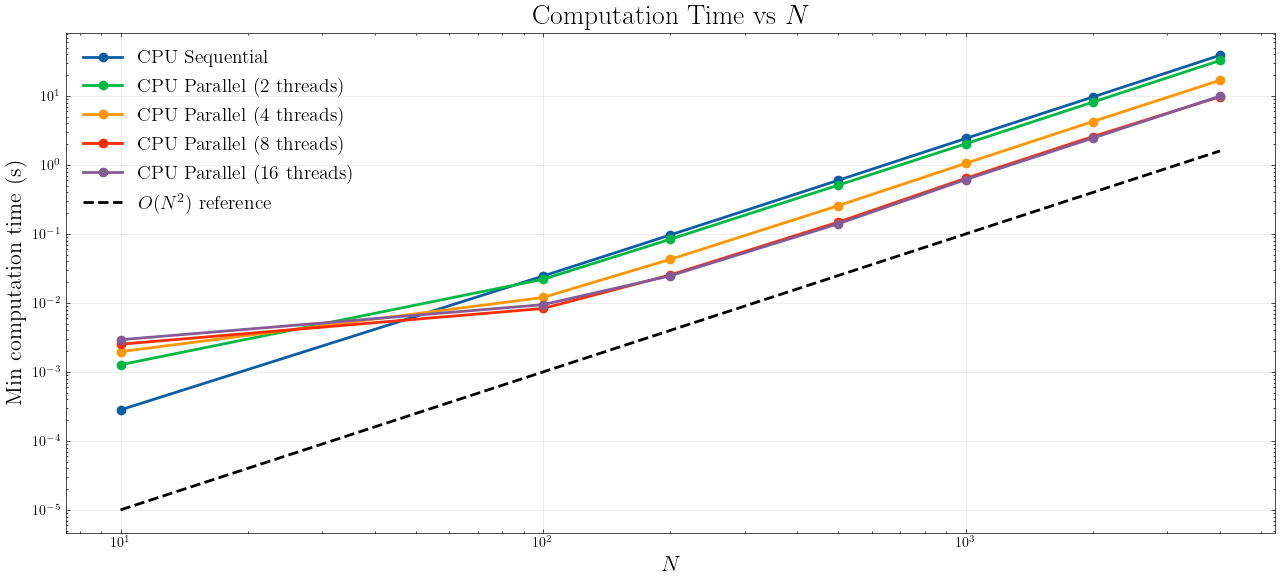

In [5]:
plt.figure(figsize=(13,6), dpi = 100)
# CP sequential
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
times = []

lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    times.append(np.min(buffer))
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"

    nParticles = []
    times = []

    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        times.append(np.min(buffer))
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)

plt.xscale('log')
plt.yscale('log')
N_ref = np.array(nParticles)
time_ref = 1e-7 * N_ref**2
plt.plot(N_ref, time_ref, '--', label=r'$O(N^2)$ reference', color='black', lw=2)
plt.title(r'Computation Time vs $N$', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Min computation time (s)', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As theoretically predicted, the execution time as a function of problem size (number of particles $N$) follows a quadratic scaling relation $O(N^2)$ for all configurations. This behavior is an intrinsic property of the naive direct-summation algorithm, which requires computing pairwise interactions between all particles. While the asymptotic trend remains quadratic, the varying slopes (representing the algorithmic pre-factors) demonstrate the efficiency of the parallel implementation: increasing the number of OpenMP threads progressively lowers the computational time for a given $N$. 

To provide a quantitative assessment of the OpenMP performance relative to the sequential baseline, we evaluate the Speedup $S_p(N)$ for each system size.

Speedup with 2 threads: 1.1869795411895232
Speedup with 4 threads: 2.299705929771853
Speedup with 8 threads: 3.892002846670381
Speedup with 16 threads: 4.015381754785828


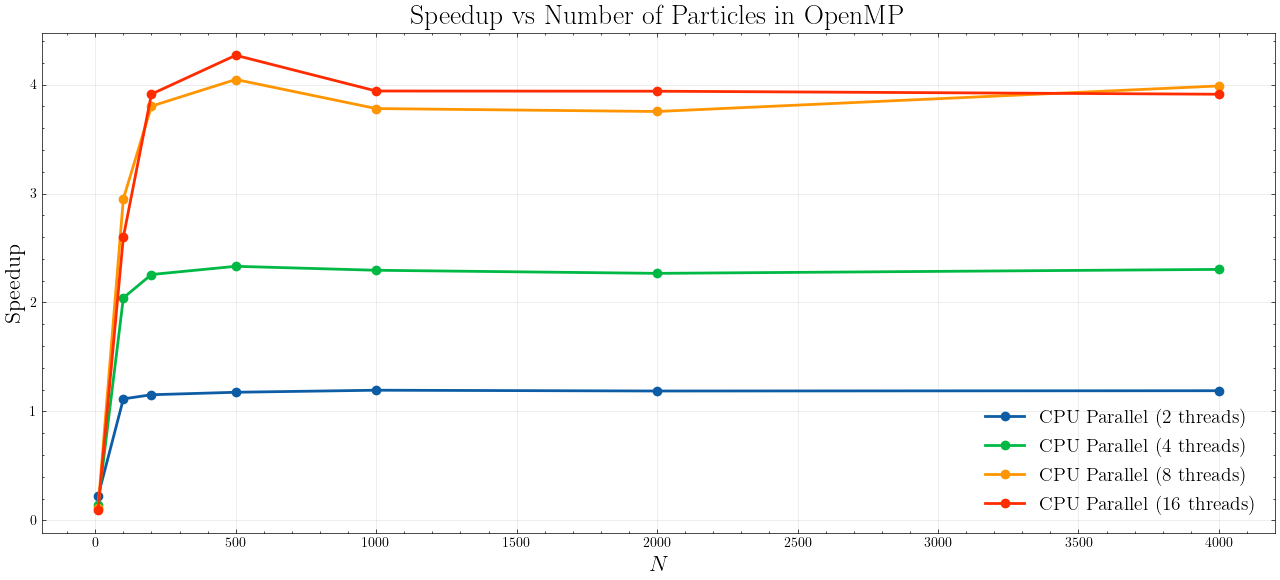

In [6]:
## Speedup in OpenMP
plt.figure(figsize=(13,6), dpi = 100)
# Sequential data
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
timesSeq = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    timesSeq.append(np.min(buffer))

timesPar = []
for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles = []
    timesPar = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        timesPar.append(np.min(buffer))
    speedup = np.array(timesSeq)/np.array(timesPar)
    plt.plot(nParticles, speedup, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Speedup with {t} threads: {np.mean(speedup[3:])}")

plt.title(r'Speedup vs Number of Particles in OpenMP', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Speedup', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As the number of threads increases, the speedup improves significantly, reaching a saturation plateau of approximately $4\times$ when utilizing 8 or 16 threads. The graph shown above allows us to draw three key conclusions regarding the performance and architecture of the simulation:

1) For sufficiently large $N$ (where parallelization overhead becomes negligible), the speedup remains roughly constant with respect to the problem complexity. This constant scaling behavior serves as a robust sanity check, confirming that the parallel overhead is well-amortized and the workload is evenly distributed among threads.

2) The speedup scales linearly up to 8 threads, but the performance gain between 8 and 16 threads is marginal. This behavior is dictated by the hardware architecture: my CPU possesses 8 physical cores. While SMT (Simultaneous Multithreading, similar to Intel HyperThreading) technology exposes 16 logical cores to the SO, pairs of threads running on the same physical core must share the same execution units (ALU/FPU). Consequently, once the 8 physical cores are saturated, enabling SMT provides only a slight throughput improvement before bottlenecking on the shared hardware resources.

3) When using $k$ threads, we might want to obtain a speedup of about $k$ (efficiency $100\%$). Here, we systematically get a speedup of about $0.5k$ (efficiency $50\%$). Why is that? The point here is that we have not been really fair. The serial implementation leverages Newton third law to reduce by half the number of computations needed to obtain the force vector. In the OpenMP implementation, this can't be done easily since threads work independently and we may encounter racae conditions if a thread updates the force on the second particle of the pair (particle j) while another thread is simultaneously attempting to write to the same memory location. Hence, the openMP implementation has to carry out twice the amount of computations performed by the sequential implementation.

We might want to explore what happens if we insist on using Newton's Third Law in parallel. One might attempt to implement a version where threads compute only the unique pairs ($j > i$) and use atomic operations (`#pragma omp atomic`) to safely update the forces on both particles (`computeForces2()`):

Speedup with 2 threads: 0.19831440211601278
Speedup with 4 threads: 0.19125953493370182
Speedup with 8 threads: 0.2741761074941586
Speedup with 16 threads: 0.6477725937059043


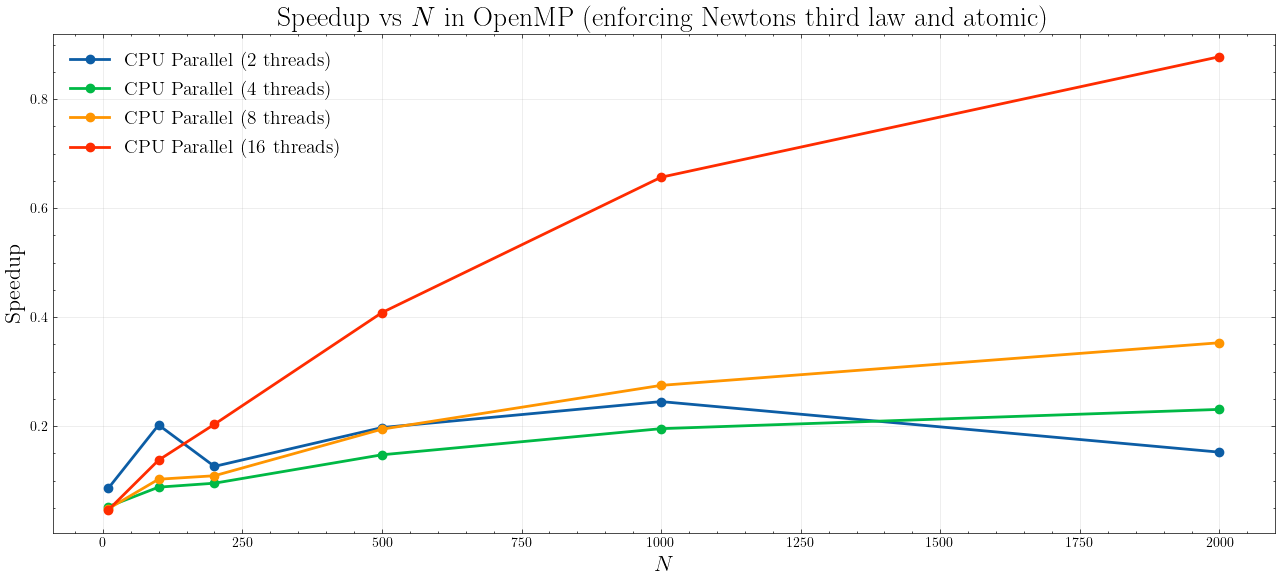

In [13]:
## Speedup in OpenMP
plt.figure(figsize=(13,6), dpi = 100)
# Sequential data
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
timesSeq = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    timesSeq.append(np.min(buffer))

timesPar = []
for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t_2.dat"
    nParticles = []
    timesPar = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        timesPar.append(np.min(buffer))
    speedup = np.array(timesSeq[:-1])/np.array(timesPar)
    plt.plot(nParticles, speedup, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Speedup with {t} threads: {np.mean(speedup[3:])}")

plt.title(r'Speedup vs $N$ in OpenMP (enforcing Newtons third law and atomic)', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Speedup', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

The outcome of this experiment is negative: the atomic implementation proves to be significantly slower than even than the sequential baseline. The computational overhead introduced by the extra synchronization required to perform the atomic sums completely overwhelms the benefit derived from halving the floating-point operations.


Interestingly, extending the parallelism to 16 threads (utilizing SMT/Hyperthreading) yields a measurable performance gain over the 8-thread configuration (still poor with respect to baseline sequential). This is to be expected, however. Since two logical threads residing on the same physical core share the same ALU/FPU resources, they cannot execute arithmetic instructions simultaneously and in parallel. However, the core's scheduler can interleave their instruction pipelines to maximize utilization. For example, when one thread is locked waiting for a  `#pragma omp atomic` operation, the sibling thread can immediately utilize these idle cycles to perform its own computations on the shared ALU. Consequently, SMT/HyperThreading effectively converts the "wasted" time of atomic synchronization into useful work, explaining the superior scaling observed in the memory-bound implementation.

As a final check, let us compute the FLOPS of our implementations (Floating Point Operation per Second). At each time step and for each particle, we have to compute:
```cpp
...
// Memory fetching
float dx = m_x[j] - m_x[i];                  (+1)
float dy = m_y[j] - m_y[i];                  (+1)
float dz = m_z[j] - m_z[i];                  (+1)
// Apply Minimum Image Criterion
dx -= m_L * std::round(dx * inv_m_L);        (+2+round)
dy -= m_L * std::round(dy * inv_m_L);        (+2+round)
dz -= m_L * std::round(dz * inv_m_L);        (+2+round)

Real r2 = dx*dx + dy*dy + dz*dz + 1e-2f;         (+7)
Real r = std::sqrt(r2);                          (+sqrt)
Real f_mag = (m_mass[i] * m_mass[j]) / (r2 * r);  (+3)
// Update forces on both i and j
m_fx[i] += f_mag * dx;                           (+2)
m_fy[i] += f_mag * dy;                           (+2)
m_fz[i] += f_mag * dz;                           (+2)
m_fx[j] -= f_mag * dx;                           (+2)
m_fy[j] -= f_mag * dy;                           (+2)
m_fz[j] -= f_mag * dz;                           (+2)
...

``` 
Let us perform a back-of-the-envelope estimate. Let us count the function `std::round` and `std::sqrt` as a 1 FLOP, hence we will have approximately $35$ FLOP at each time step. Considering we take $1000$ integration step computing $N^2/2$ forces (or $N^2$), we have:
$$
GFLOPS_{serial} \approx \frac{35 N^2 N_{step}}{2t_{min}\times 10^9}
$$
$$
GFLOPS_{parallel} \approx \frac{35 N^2 N_{step}}{t_{min}\times 10^9}
$$
N.B. To be precise, we should count the FLOP needed to integrate the equations of motion (either with Euler or Verlet) as well. The formula is similar to the one reported above apart from the linear scaling $O(N)$. When $N$ is sufficiently large, we can safely ignore this contribution with respect to the $O(N^2)$ term due to the force computation

Average GFLOPS (sequential): 7.229107916490824
Speedup on GFLOPs with 2 threads: 2.3739153566316857
Speedup on GFLOPs with 4 threads: 4.599488798705559
Speedup on GFLOPs with 8 threads: 7.784190247918623
Speedup on GFLOPs with 16 threads: 8.03180962267365


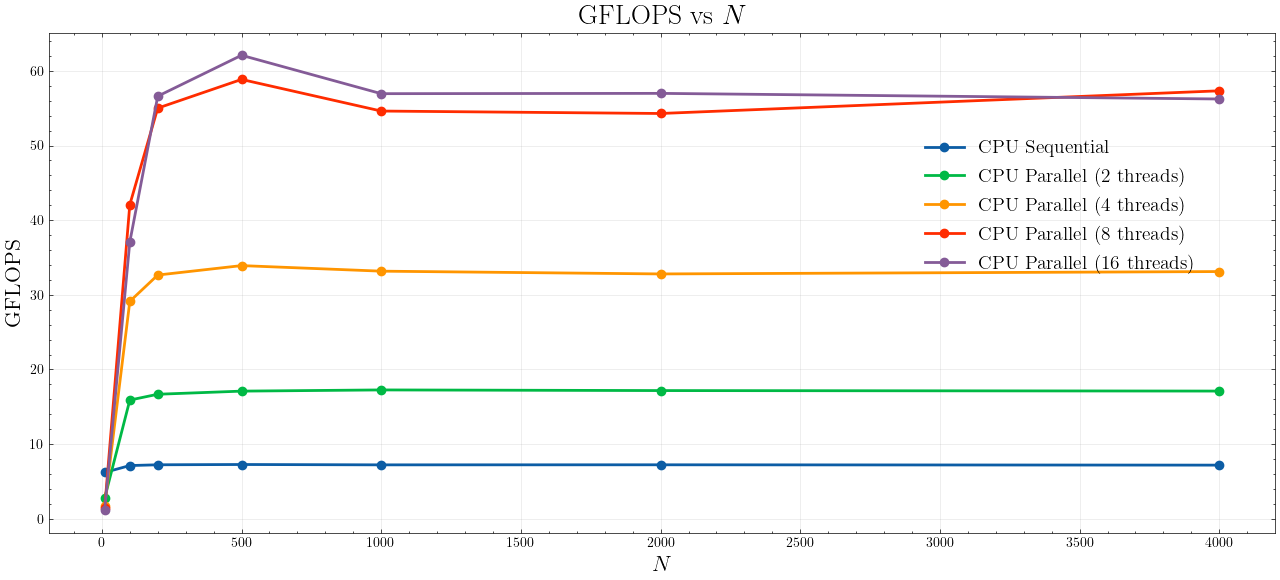

In [8]:
steps = 1000
ops_per_interaction = 35.0  # an approx, of course
REP = 15
threads = [2, 4, 8, 16]
plt.figure(figsize=(13,6), dpi = 100)


nParticles = []
times = []
filename = "../data/CPUSequential/timeVersusN.dat"
lines = open(filename).read().splitlines()
avgGFLOPS = 0
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
    times.append(total_ops / (2*np.min(buffer)*1e9))  # Convert to GFLOPS
avgGFLOPS = np.mean(times[3:])
print(f"Average GFLOPS (sequential): {avgGFLOPS}")
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles = []
    times = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
        times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Speedup on GFLOPs with {t} threads: {np.mean(times[3:])/avgGFLOPS}")

plt.title(r'GFLOPS vs $N$', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'GFLOPS', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, bbox_to_anchor=(0.7, 0.82) )
plt.tight_layout()
plt.show()

The GFLOPS analysis reveals the true efficiency of the parallel implementation, resolving the apparent discrepancy observed in the speedup charts. Remarkably, when utilizing 8 threads, we observe a computational throughput that is approximately 7 times higher than the serial baseline (a better efficiency!)

This result confirms that the bottleneck in the speedup (which is limited to $\approx 4\times$) is purely algorithmic, not architectural. By calculating the full interaction matrix ($N^2$) instead of unique pairs ($N^2/2$), the parallel implementation performs exactly twice the amount of useful work per time step. The fact that the GFLOPS metric scales linearly with the physical core count proves that the OpenMP overhead is negligible and that the memory subsystem is successfully feeding data to all 8 cores simultaneously without significant contention.


## GPU programming with CUDA
The parallel GPU implementation was executed on the integrated GPU of the NVIDIA Jetson Nano. Unlike discrete desktop GPUs, this unit is built directly into the Tegra X1 SoC and shares the main system memory (DRAM).

| Feature | Specification |
| :--- | :--- |
| **GPU Architecture** | NVIDIA Maxwell |
| **Compute Capability** | 5.3 |
| **CUDA Cores** | 128 |
| **Streaming Multiprocessors (SMP)** | 1 |
| **Clock Frequency** | 921 MHz |
| **Global Memory** | Shared with CPU (4GB LPDDR4 total system RAM) |
| **Memory Bandwidth** | 25.6 GB/s (Theoretical Peak shared) |
| **Max Threads per Block** | 1024 |
| **Max Shared Memory per Block** | 48 KB |
| **Compiler** | nvcc, flags: -O3 --use_fast_math|

Let us start analyzing the speedup as we did before with the OpenMP implementation:

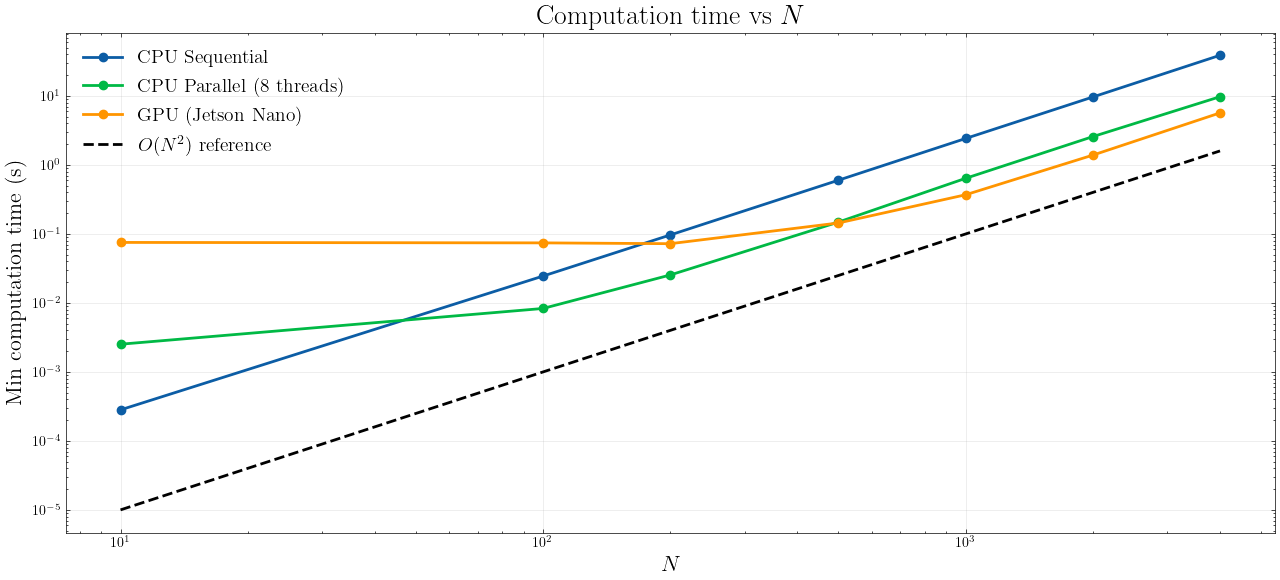

In [14]:
plt.figure(figsize=(13,6), dpi = 100)
# CP sequential
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [8]

nParticles = []
times = []

lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    times.append(np.min(buffer))
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"

    nParticles = []
    times = []

    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        times.append(np.min(buffer))
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)

filename = "../data/GPU/timeVersusN.dat"
nParticles = []
times = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    times.append(np.min(buffer))
plt.plot(nParticles[:-2], times[:-2], '-o', label='GPU (Jetson Nano)', lw = 2)

plt.xscale('log')
plt.yscale('log')
N_ref = np.array(nParticles[:-2])
time_ref = 1e-7 * N_ref**2
plt.plot(N_ref, time_ref, '--', label=r'$O(N^2)$ reference', color='black', lw=2)
plt.title(r'Computation time vs $N$', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Min computation time (s)', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In the figure above, we compare the sequential baseline, the 8-thread OpenMP version, and the GPU implementation (again, using the minimum execution time as before). In the GPU implementation, the timer was started and finished considering the time needed to launch the kernels and to load the initial settings (as computed beforehand by the CPU) into the VRAM. On the Jetson Nano, the host (CPU) and device (GPU) share the same physical RAM, which reduces data transfer latency. However, even in systems with two distinct VRAM, I chose to include these overheads to ensure a "fair" comparison.

Looking at the graph above, we see that for small $N$, the GPU performance is poor, as execution is dominated by kernel launch overhead and driver latency rather than actual computation (latency bound). However, around $N \approx 1000$, the workload becomes sufficient to saturate the GPU cores. From this crossover point onwards, the GPU successfully amortizes the overhead, effectively hiding memory latency, and ultimately outperforms the multi-threaded CPU implementation following the usual $O(N^2)$ scaling behavior

Let's plot the speedup for both 8-OpenMP and GPU:

Mean Speedup with 8 threads: 3.87
Mean Speedup with GPU: 6.90


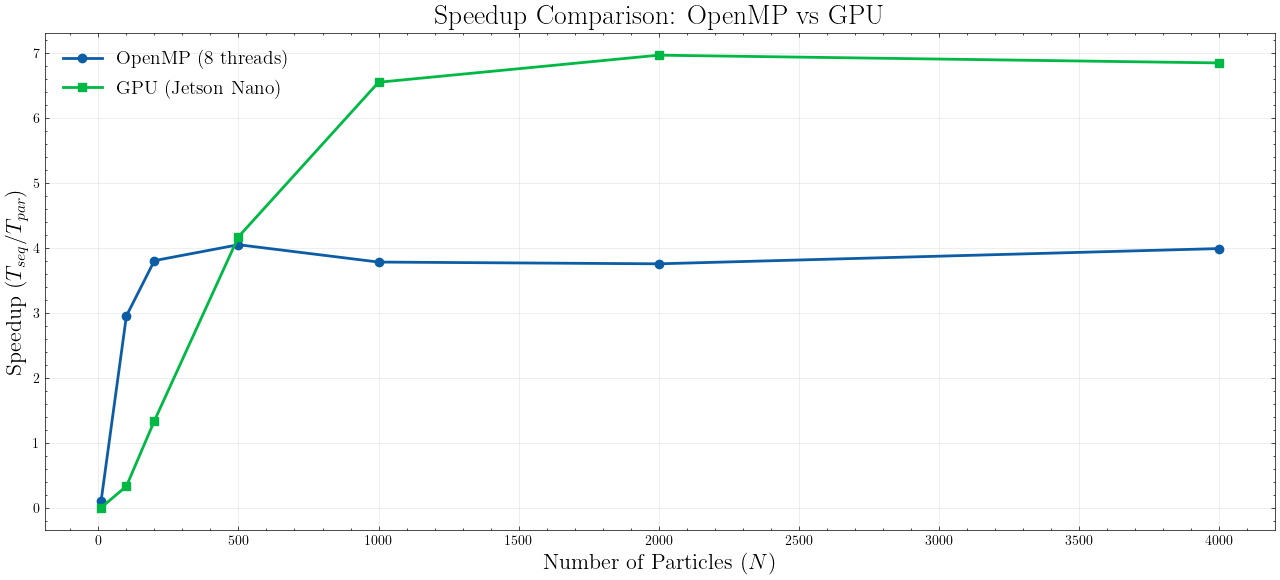

In [15]:
plt.figure(figsize=(13,6), dpi = 100)

REP = 15

filename_seq = "../data/CPUSequential/timeVersusN.dat"
nParticles_seq = []
timesSeq = []

lines = open(filename_seq).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    if not block: continue
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles_seq.append(np.min(bufferParticles))
    timesSeq.append(np.min(buffer))

timesSeq = np.array(timesSeq) 

threads = [8] 
for t in threads:
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles_par = []
    timesPar = []

    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        if not block: continue
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles_par.append(np.min(bufferParticles))
        timesPar.append(np.min(buffer))

    min_len = min(len(timesSeq), len(timesPar))
    speedup_cpu = timesSeq[:min_len] / np.array(timesPar[:min_len])
    
    plt.plot(nParticles_par[:min_len], speedup_cpu, '-o', label=f'OpenMP ({t} threads)', lw = 2)
    print(f"Mean Speedup with {t} threads: {np.mean(speedup_cpu[5:]):.2f}")


filename_gpu = "../data/GPU/timeVersusN.dat"
nParticles_gpu = []
timesGPU = []

lines = open(filename_gpu).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    if not block: continue
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles_gpu.append(np.min(bufferParticles))
    timesGPU.append(np.min(buffer))

min_len = min(len(timesSeq), len(timesGPU))

speedup_gpu = timesSeq[:min_len] / np.array(timesGPU[:min_len])

plt.plot(nParticles_gpu[:min_len], speedup_gpu, '-s', label='GPU (Jetson Nano)', lw = 2)
print(f"Mean Speedup with GPU: {np.mean(speedup_gpu[5:]):.2f}")

# Formattazione
plt.title(r'Speedup Comparison: OpenMP vs GPU', fontsize=20)
plt.xlabel(r'Number of Particles ($N$)', fontsize=16)
plt.ylabel(r'Speedup ($T_{seq} / T_{par}$)', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Let's plot again the GFLOPS. As we did before, we are going to assume a fixed number of Floating Point Operations per each time step ($\approx 35$).


To measure the performance of the GPU implementation, we employed the same methodology used for the CPU versions, leveraging the C++ Standard Template Library (STL) std::chrono APIs. We recorded the wall-clock time required for the `integrateVerletGPU(...)` function to complete, ensuring a final synchronization between the host and the device via `cudaDeviceSynchronize()`. By adopting this approach, we partially include the time spent on the CPU for setup (such as initializing `std::ofstream` objects) and for managing host-side variables (`time`, `isSavingStep`). However, these operations have a negligible impact on the total timing as they scale as $O(1)$ or $O(N)$. For large values of $N$, the execution time is overwhelmingly dominated by the GPU's $O(N^2)$ force computations. Furthermore, the CPU execution is asynchronous with respect to the GPU. The CPU dispatches kernels one after another into the command queue without waiting for the GPU to finish executing them. If $N$ is sufficiently large, the CPU will finish dispatching all kernels well before the GPU completes its processing. Therefore, the measured time correctly reflects the GPU computational workload

Consequently, the measured wall-clock time should provide an accurate representation of the device's actual processing performance

Average GFLOPS (sequential): 7.210303526877489
Average GFLOPs with 8 threads: 55.8098146174615
Average GFLOPS (GPU): 106.809131134565


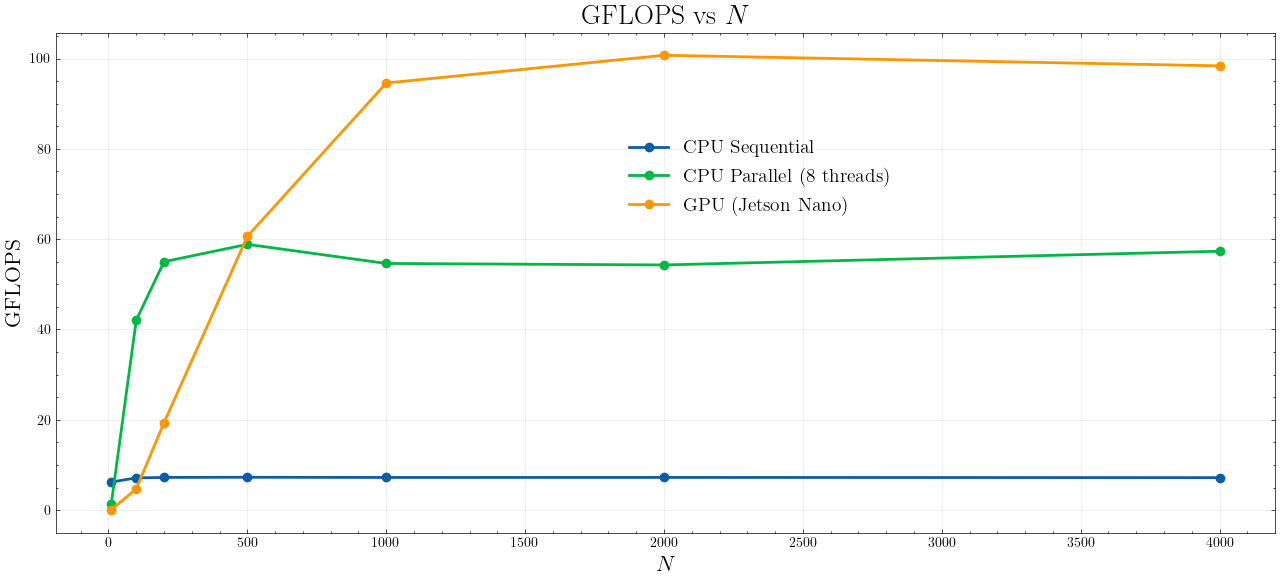

In [11]:
steps = 1000
ops_per_interaction = 35.0  # an approx, of course
REP = 15
threads = [8]
plt.figure(figsize=(13,6), dpi = 100)


nParticles = []
times = []
filename = "../data/CPUSequential/timeVersusN.dat"
lines = open(filename).read().splitlines()
avgGFLOPS = 0
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
    times.append(total_ops / (2*np.min(buffer)*1e9))  # Convert to GFLOPS
avgGFLOPS = np.mean(times[5:])
print(f"Average GFLOPS (sequential): {avgGFLOPS}")
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles = []
    times = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
        times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Average GFLOPs with {t} threads: {np.mean(times[5:])}")

nParticles = []
times = []
filename = "../data/GPU/timeVersusN.dat"
lines = open(filename).read().splitlines()
avgGFLOPS = 0
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
    times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
avgGFLOPS = np.mean(times[5:])
print(f"Average GFLOPS (GPU): {avgGFLOPS}")
plt.plot(nParticles[:-2], times[:-2], '-o', label='GPU (Jetson Nano)', lw = 2)

plt.title(r'GFLOPS vs $N$', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'GFLOPS', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, bbox_to_anchor=(0.7, 0.82) )
plt.tight_layout()
plt.show()

The experimental results align closely with our theoretical expectations. The GPU implementation achieves approximately $100$ GFLOPS, performing $14\times$ better over the sequential CPU baseline and a $2\times$ performance increase compared to the 8-thread OpenMP implementation.

On paper, the NVIDIA Jetson Nano is rated for 472 GFLOPS in half-precision (FP16) and 236 GFLOPS in single-precision (FP32), which is the format used in this simulation. Our implementation, therefore, reaches approximately 42% of the theoretical peak performance, which is satisfactory.


We can also evaluate the memory bandwidth, e.g. the amount of bytes transferred (from the device RAM) over time. The procedure is similar to the one adopted to compute the FLOPS: at each timestep (considering only the $O(N^2)$ computeForce() function) we are requesting $4N$ bytes of data from the memory. In particular, each kernel has to load in memory for all $N$ particles their mass and positions, i.e. $4$ `float` or $16 \> B$. This has to be repeated for all kernel ($N$ of them) for all timesteps, hence:
$$
B = \frac{16\cdot N^2 \cdot N_{step}}{t_{min}}
$$
measured in bytes per second. When $N = 4000$, then $t_{min} \approx 5.7$ hence $B \approx 45 \> GB / s$. This is well above the theoretical limit for the Jetson Nano $B_{max} = 25.6 \> GB / s$. This fact indicates that the simulation is not strictly fetching data from the off-chip memory (DRAM) at every request. Instead, this high throughput is made possible by the GPU memory hierarchy, presumably the L2 Cache (which is way faster than the device memory). In fact, we know that the Jetson Nano has a $256 \> kB$ L2 cache that can easily fit three position arrays and a mass array as long as $N$:
$$
3\cdot N(4 \> B) + N\cdot (4 \> B) \leq 256000 \> B
$$
This is true as long as $N < 16000$. 

## GPU (Tiling)
Can we do better? We can try with tiling, trying to program ourselves the shared memory. Shared Memory is a user-managed cache that resides on the SMPs, offering much lower latency and higher bandwidth than the VRAM. The core idea of Tiling is to divide the $N$ particles into small blocks (tiles) that fit into this shared memory.

The fundamental difference is that now, instead of each thread independently reading particle data from the slow device memory (or hoping for an L2 cache hit), the threads within a block collaborate to load a tile of data into the shared memory once. They then perform calculations reading from this fast, on-chip memory. This should reduces the traffic to the global memory by a factor equal to the number of threads per block (or the tile size). Let's see what we get:

Average GFLOPs without tiling: 106.809131134565
Average GFLOPs with block size 128: 114.60437825658543
Average GFLOPs with block size 256: 115.84144720519718
Average GFLOPs with block size 512: 117.19469074389235
Average GFLOPs with block size 1024: 117.4783001375119


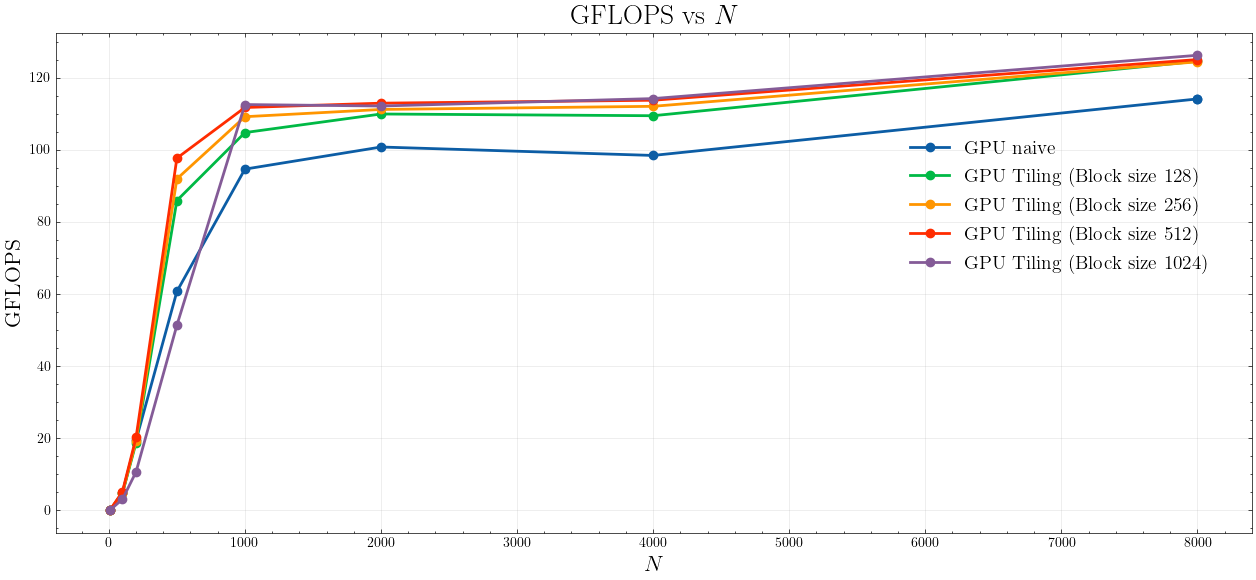

In [12]:
steps = 1000
ops_per_interaction = 35.0  # an approx, of course
REP = 15
blocksize = [128, 256, 512, 1024]

plt.figure(figsize=(13,6), dpi = 100)

filename = f"../data/GPU/timeVersusN.dat"
nParticles = []
times = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
    times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
plt.plot(nParticles, times, '-o', label=f'GPU naive', lw = 2)
print(f"Average GFLOPs without tiling: {np.mean(times[5:])}")


for b in blocksize:
    filename = f"../data/GPU/timeVersusN_Tiling{b}.dat"
    nParticles = []
    times = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
        times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
    plt.plot(nParticles, times, '-o', label=f'GPU Tiling (Block size {b})', lw = 2)
    print(f"Average GFLOPs with block size {b}: {np.mean(times[5:])}")

plt.title(r'GFLOPS vs $N$', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'GFLOPS', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, bbox_to_anchor=(0.7, 0.82) )
plt.tight_layout()
plt.show()

Unfortunately, implementing the tiling strategy did not yield a dramatic performance increase compared to the naive implementation. Still, this outcome is consistent with our bandwidth analysis and fully expected. As demonstrated in the previous section, the dataset for $N=4000$ (but also $N = 8000$) is sufficiently compact to fit entirely within the GPU's L2 Cache, which is automatically managed by the hardware controller. Consequently, the naive implementation was already enjoying high-speed, on-chip memory access, effectively bypassing the global memory bottleneck. Since the simulation was already operating in a compute-bound regime rather than a memory-bound one, the transition to explicit memory management via shared memory resulted in only marginal performance gains.

----


Output of `./deviceQuery`:
(mcp) jetson@jetson:/usr/local/cuda/samples/1_Utilities/deviceQuery$ ./deviceQuery
./deviceQuery Starting...

 CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "NVIDIA Tegra X1"
  CUDA Driver Version / Runtime Version          10.2 / 10.2

  CUDA Capability Major/Minor version number:    5.3

  Total amount of global memory:                 1980 MBytes (2075893760 bytes)
  
  ( 1) Multiprocessors, (128) CUDA Cores/MP:     128 CUDA Cores
  
  GPU Max Clock rate:                            922 MHz (0.92 GHz)
  
  Memory Clock rate:                             13 Mhz
  
  Memory Bus Width:                              64-bit
  
  L2 Cache Size:                                 262144 bytes
  
  Maximum Texture Dimension Size (x,y,z)         1D=(65536), 2D=(65536, 65536), 3D=(4096, 4096, 4096)
  
  Maximum Layered 1D Texture Size, (num) layers  1D=(16384), 2048 layers
  
  Maximum Layered 2D Texture Size, (num) layers  2D=(16384, 16384), 2048 layers
  
  Total amount of constant memory:               65536 bytes
  
  Total amount of shared memory per block:       49152 bytes
  
  Total number of registers available per block: 32768
  
  Warp size:                                     32
  
  Maximum number of threads per multiprocessor:  2048
  
  Maximum number of threads per block:           1024
  
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)
  
  Maximum memory pitch:                          2147483647 bytes
  
  Texture alignment:                             512 bytes
  
  Concurrent copy and kernel execution:          Yes with 1 copy engine(s)
  
  Run time limit on kernels:                     Yes
  
  Integrated GPU sharing Host Memory:            Yes
  
  Support host page-locked memory mapping:       Yes
  
  Alignment requirement for Surfaces:            Yes
  
  Device has ECC support:                        Disabled
  
  Device supports Unified Addressing (UVA):      Yes
  
  Device supports Compute Preemption:            No
  
  Supports Cooperative Kernel Launch:            No
  
  Supports MultiDevice Co-op Kernel Launch:      No
  
  Device PCI Domain ID / Bus ID / location ID:   0 / 0 / 0
  
  Compute Mode:  Default (multiple host threads can use ::cudaSetDevice() with device simultaneously) 



deviceQuery, CUDA Driver = CUDART, CUDA Driver Version = 10.2, CUDA Runtime Version = 10.2, NumDevs = 1

Result = PASS

